In [1]:
%matplotlib notebook
import os, sys
from matplotlib import pyplot
from sklearn.metrics import roc_curve, roc_auc_score

sys.path.append('/root/cAAE')
from model.tools.config import Config, read_conf
from model.generator import generator, net

import torch
torch.backends.cudnn.benchmark=True

config = read_conf(f'/root/cAAE/config/{os.environ["CONFIG_NAME"]}.json')

In [2]:
def plot_all_axis(brain):
    n=2/3
    fig, axs = pyplot.subplots(1, 3)
    axs[0].imshow(brain[int(brain.shape[0]*n), :, :])
    axs[0].set_title('Brain axis = 0')
    axs[1].imshow(brain[:, int(brain.shape[1]*n), :])
    axs[1].set_title('Brain axis = 1')
    axs[2].imshow(brain[:, :, int(brain.shape[1]*n)])
    axs[2].set_title('Brain axis = 2')

Первым делом получим датасет для теста. Регулируя `config.test.max_batch`, можно менять размер датасета

In [3]:
# config.test.max_batch = 5
dataset = generator(config, train_flg=False)
config.transforms += {'img_shape': dataset.get_img_shape()}

Теперь получим саму сетку (можно изменить в `config.struct.name`). Также можно менять:
* `config.test.thickness` - предполагаемый размер стенки мозга (если 0, то граница вообще не удаляется)
* `config.test.acc` - допустимая ошибка восстановления (от 0 до 1)

In [4]:
# config.struct.name = 'ResDCGAN'
config.struct.name = 'AAE'
# config.test.thickness = 2
model = net[config.struct.name](config, train_flg=False)
load_path = '/root/weights'
model.load(load_path)

[Cuda: True]


Рассмотрим что происходит в рамках одного среза

<IPython.core.display.Javascript object>


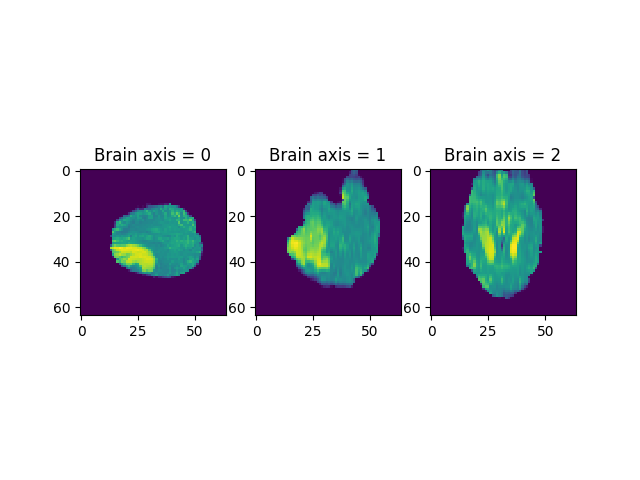

In [5]:
test_person = dataset.get_person(idx=11)
test_brain = test_person(dataset.transform)
plot_all_axis(test_brain)

Сначала посмотрим чистое восстановление (`acc = 0`) и без удаления границ (`thickness = 0`)

In [7]:
model.config.test.thickness = 0
recovered_brain, restore_tumor = model.recover(test_person, dataset.transform, 0)

<IPython.core.display.Javascript object>


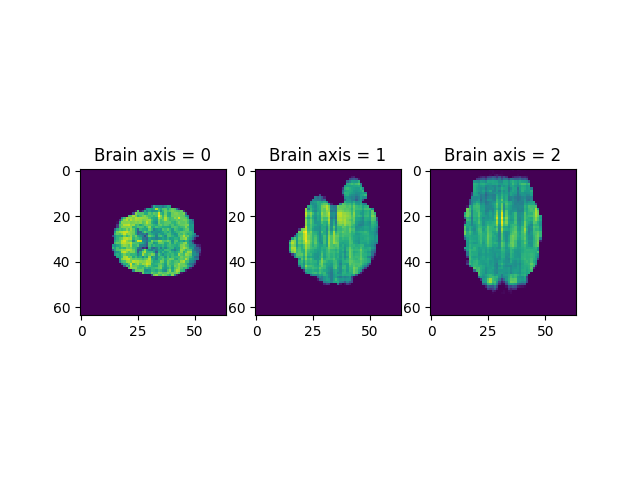

In [9]:
import torch
test_brain_tensor = test_person(dataset.transform).type(model.Tensor)
recovered_brain = model.decoder(model.encoder(test_brain_tensor)).data.cpu()
# get mask
mask = test_person.get_mask()
recovered_brain *= dataset.transform(mask)
recovered_brain = torch.clamp(recovered_brain, 0, 1)

plot_all_axis(recovered_brain)

А теперь взглянем на опухоль

<IPython.core.display.Javascript object>


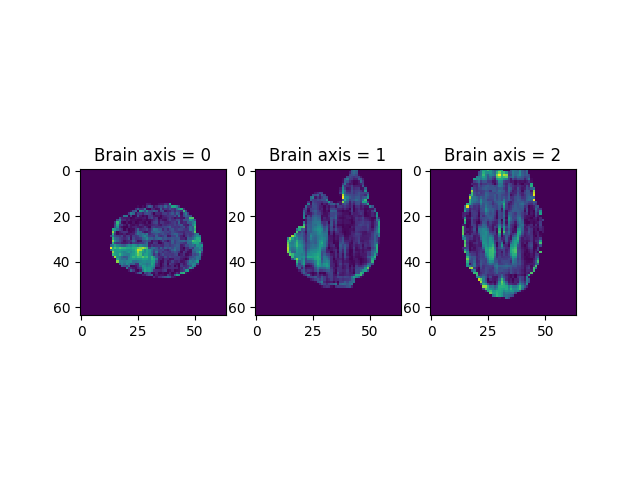

In [10]:
restore_tumor = abs(recovered_brain - test_brain_tensor.cpu())
plot_all_axis(restore_tumor)

А теперь с отсечкой

<IPython.core.display.Javascript object>


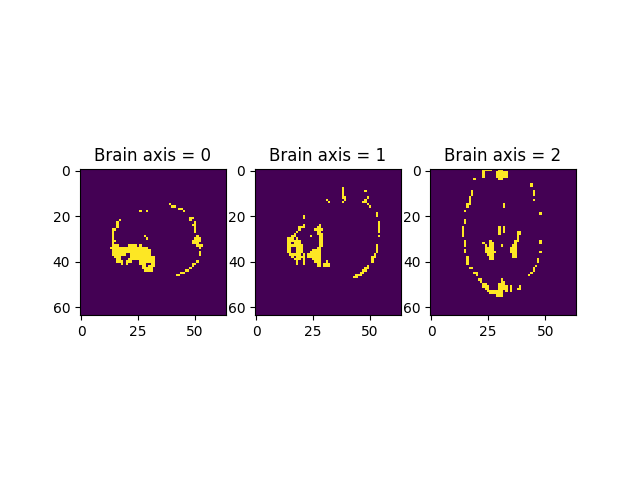

In [11]:
model.config.test.acc = 0.3
restore_tumor[restore_tumor <= model.config.test.acc] = 0
restore_tumor[restore_tumor > model.config.test.acc] = 1
plot_all_axis(restore_tumor)

Удалим черепную коробку

<IPython.core.display.Javascript object>


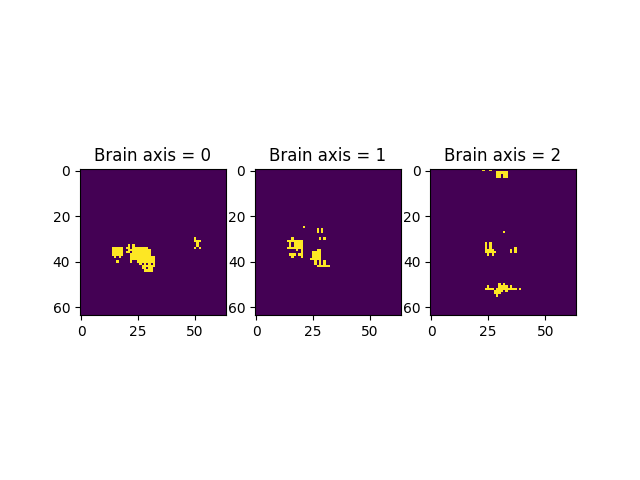

In [12]:
model.config.test.thickness = 2
recovered_brain, restore_tumor = model.recover(test_person, dataset.transform, model.config.test.acc)
plot_all_axis(restore_tumor)

Можно выбрать одну из двух метрик: `iou` или `sd`

In [13]:
model.config.test.metric == 'sd'
test_tumor_tensor = test_person.get_tumor(dataset.transform)
test, target = model.calc_metric(restore_tumor, test_tumor_tensor)
test, target

(tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5455e-08,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.8358e-01, 3.1650e-01, 3.1804e-01, 3.1268e-01, 3.3425e-01,
         2.9708e-01, 4.4286e-01, 4.0855e-01, 3.9243e-01, 4.3146e-01, 4.3836e-01,
         4.4493e-01, 5.6034e-01, 4.6667e-01, 5.4589e-01, 6.3636e-01, 6.8665e-01,
         6.6077e-01, 5.0360e-01, 2.9956e-01, 2.2346e-01, 0.0000e+00, 1.9149e-01,
         1.6260e-01, 1.8898e-01, 2.7397e-08, 4.0000e-08, 2.8571e-08, 4.5455e-08,
         4.7619e-08, 2.9412e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

Ну и итог

tumor loss: 0.125


<IPython.core.display.Javascript object>


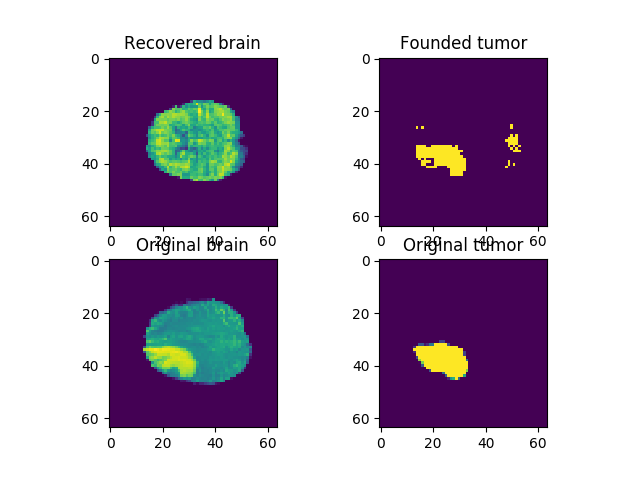

In [14]:
model.test_show(dataset, acc=0.25, idx=11)